In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import janitor


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In this notebook, I will simulate data that we will use to answer a "click data" question.

The question at hand is this: We want to run an experiment on our website, in which we measure the conversion rate of our customers. Our customers are searching for flights, and we have collected the number of clicks that they have made before making their purchases.

In [2]:
import pandas_flavor as pf

@pf.register_dataframe_method
def find_replace(df, column, mapper):
    df = df.copy()
    df[column] = df[column].apply(lambda x: mapper.get(x, x))
    return df


mapper = {'ctrl': 0, 'grp1': 1, 'grp2': 2}

In [3]:
# Experiment 1 Parameters
p_1 = 0.06  # 90% of customers do not click anything at all.
mu_1 = 2  # mu/(mu+alpha) gives probability of stopping at each chance.
alpha_1 = 6  # number of trials until stopping
# (the probability of successfully buying per trial is 6/8)

# Experiment 2 Parameters
p_2 = 0.11
mu_2 = 3  
alpha_2 = 4

# Experiment 3 Parameters
p_3 = 0.13
mu_3 = 1
alpha_3 = 3

In [4]:
with pm.Model() as expt1_sim:
    ctrl = pm.ZeroInflatedNegativeBinomial('ctrl', mu=mu_1, alpha=alpha_1, psi=p_1)
    grp1 = pm.ZeroInflatedNegativeBinomial('grp1', mu=mu_2, alpha=alpha_2, psi=p_2)
    grp2 = pm.ZeroInflatedNegativeBinomial('grp2', mu=mu_3, alpha=alpha_3, psi=p_3)

In [5]:
data = (
    pd.DataFrame(pm.sample_prior_predictive(3000, expt1_sim))
    .melt(
        id_vars=None, 
        value_vars=['ctrl', 'grp1', 'grp2'],
        var_name='experiment_group',
        value_name='clicks'
    )
    .label_encode('experiment_group')
)

In [6]:
print(data.query("clicks != 0").select_columns(['experiment_group', 'clicks']).sample(10))

     experiment_group  clicks
4532             grp1       5
1097             ctrl       1
6769             grp2       1
1417             ctrl       2
3395             grp1       2
8460             grp2       1
6162             grp2       1
604              ctrl       3
4996             grp1       4
4265             grp1       3


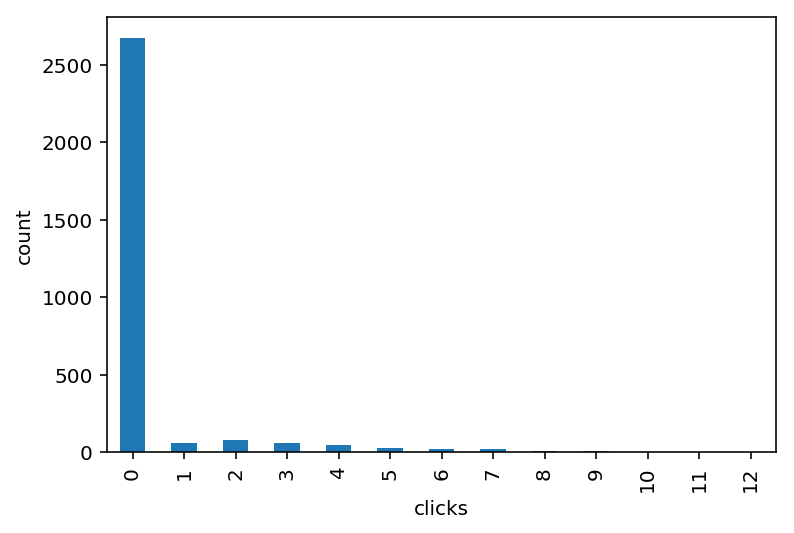

In [14]:
ax = data.query('experiment_group == "grp1"').groupby('clicks').count()['experiment_group'].plot(kind='bar')
ax.set_ylabel('count')
plt.savefig('../images/clicks.png', dpi=300, bbox_inches='tight', transparent=True)

In [15]:
with pm.Model() as model:
    mu_prior_lam = pm.HalfCauchy('mu_prior_lam', beta=1)
    mu = pm.HalfNormal('mu', sd=mu_prior_lam, shape=(3,))
    mu_enc = mu[data['experiment_group_enc']]

    alpha_prior_lam = pm.HalfCauchy('alpha_prior_lam', beta=1)
    alpha = pm.HalfNormal('alpha', sd=alpha_prior_lam, shape=(3,))
    alpha_enc = alpha[data['experiment_group_enc']]
    
    # Model the probability of purchasing.
    p_purchase = pm.Deterministic('p_purchase', mu / (mu + alpha))  

    p = pm.Beta('p', alpha=1, beta=1, shape=(3,))
    p_enc = p[data['experiment_group_enc']]
    
    like = pm.ZeroInflatedNegativeBinomial('like', mu=mu_enc, alpha=alpha_enc, psi=p_enc, observed=data['clicks'])

/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [16]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, alpha, alpha_prior_lam, mu, mu_prior_lam]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]/Users/maer3/anaconda/envs/abcde-testing/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an erro

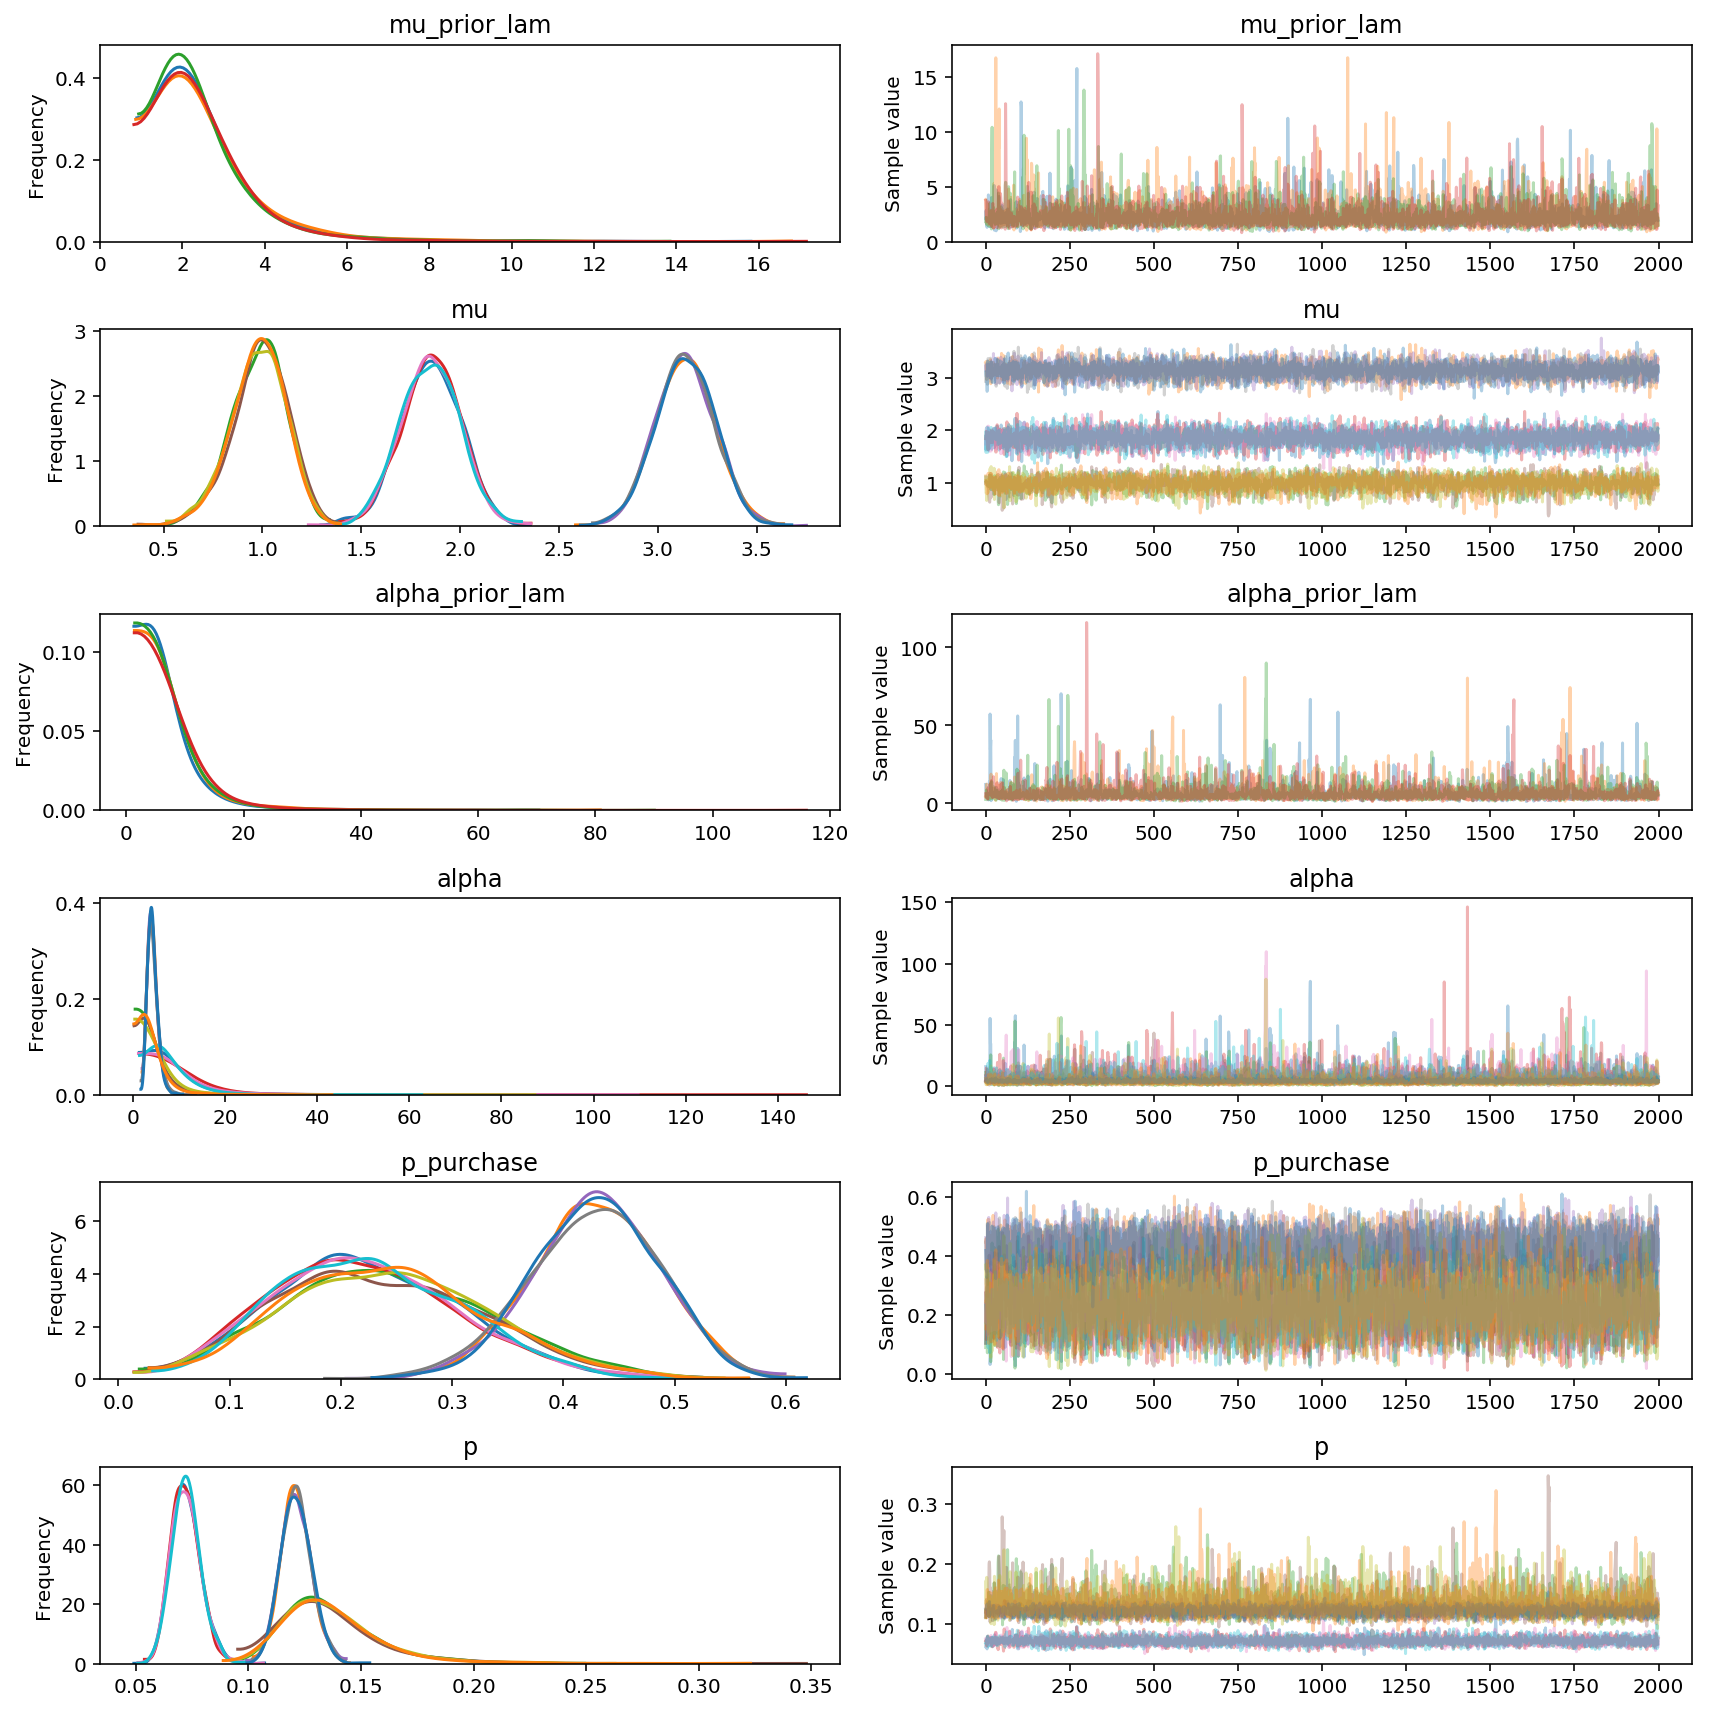

In [31]:
pm.traceplot(trace)
plt.savefig('../images/click.posterior.trace.png', dpi=300, transparent=True)

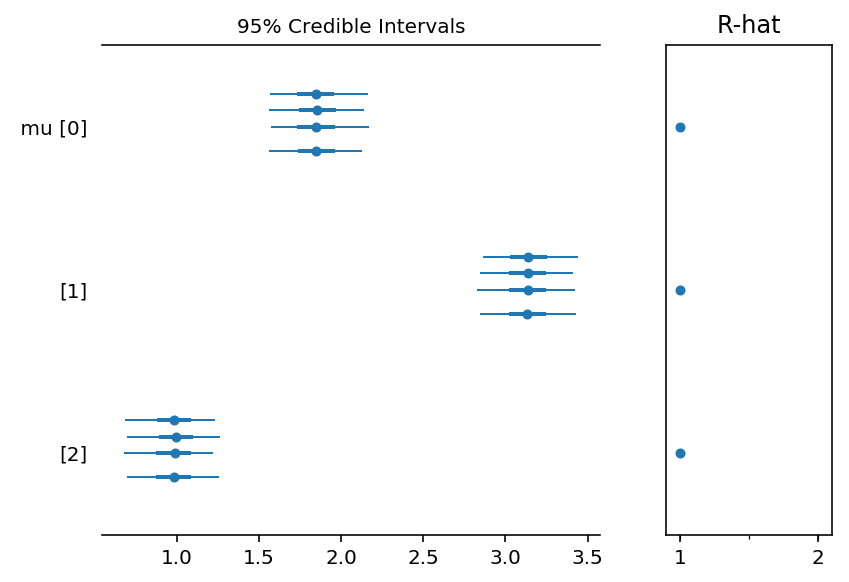

In [27]:
pm.forestplot(trace, varnames=['mu'])
plt.savefig('../images/click.mu.forest.png', dpi=300, transparent=True)

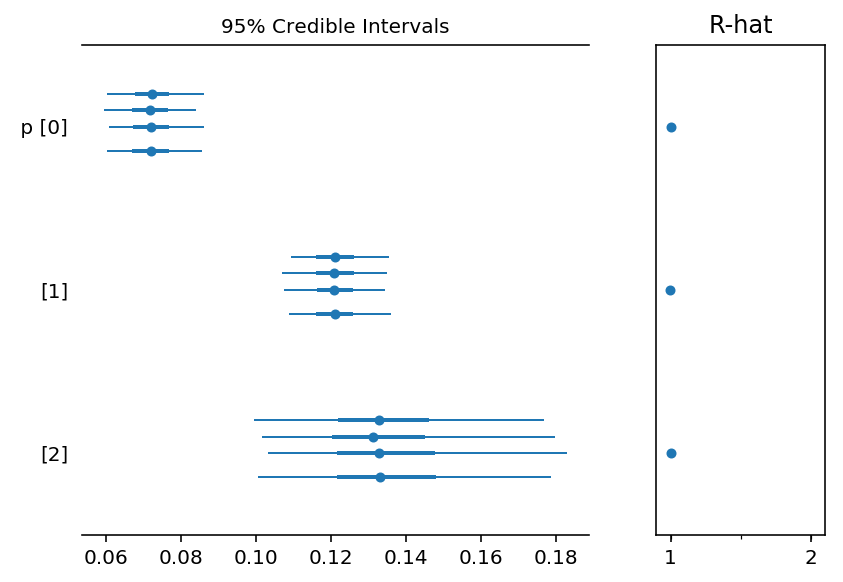

In [28]:
pm.forestplot(trace, varnames=['p'])
plt.savefig('../images/click.p.forest.png', dpi=300, transparent=True)

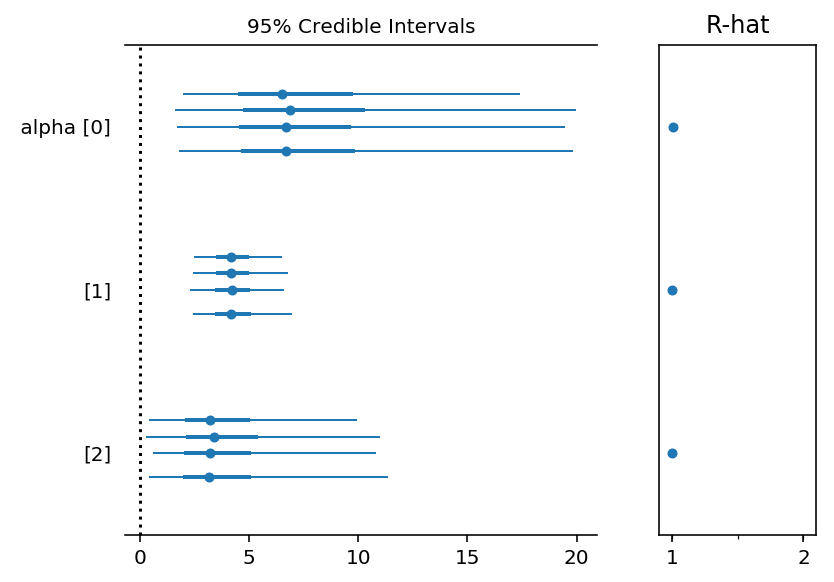

In [29]:
pm.forestplot(trace, varnames=['alpha'])
plt.savefig('../images/click.alpha.forest.png', dpi=300, transparent=True)

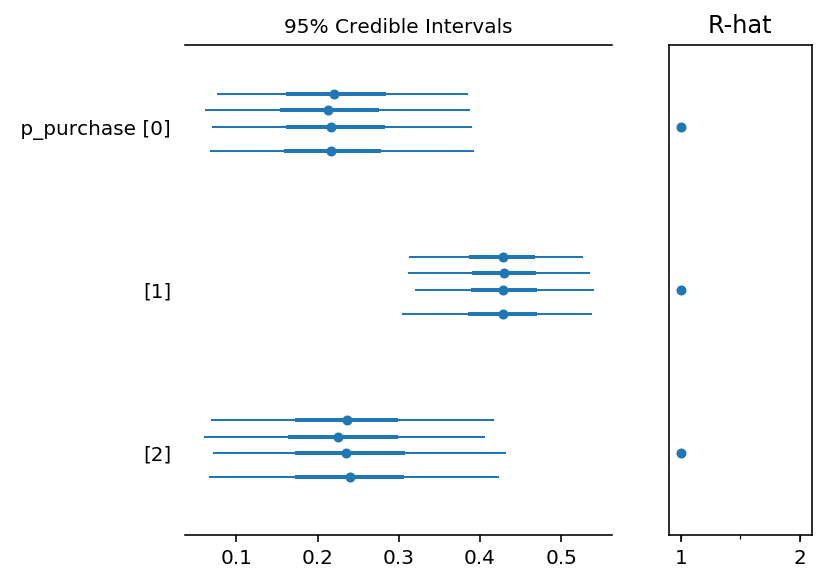

In [30]:
pm.forestplot(trace, varnames=['p_purchase'])
plt.savefig('../images/click.p_purchase.forest.png', dpi=300, transparent=True)